In [1]:
import re
from pathlib import Path

import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt

from typing import Optional, Tuple, Dict, Any, Sequence


data_dir = "./data"
print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [2]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [3]:
data_dict = load_measurements("data/", "w_*.txt")

keys_amp = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
keys_pha = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]
dict_amp = {k: data_dict[k] for k in keys_amp}
dict_pha = {k: data_dict[k] for k in keys_pha}

loader_amp = MultiBasisDataLoader(dict_amp, batch_size=128)
loader_pha = MultiBasisDataLoader(dict_pha, batch_size=128)

In [11]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1
    n_chains: int = 1000

    @nn.compact
    def __call__(self, data_batch: jnp.ndarray, aux_vars: Optional[Dict[str, Any]] = None) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        b = self.param("b", nn.initializers.zeros,        (self.n_visible,))
        c = self.param("c", nn.initializers.zeros,        (self.n_hidden,))
        key = aux_vars["key"]

        key, bern_key = jax.random.split(key, 2)
        v_chain_batch = jax.random.bernoulli(bern_key, p=0.5, shape=(self.n_chains, self.n_visible)).astype(jnp.float32)
        model_batch, key = self._gibbs_sample(W, b, c, v_chain_batch, key, k=self.k)
        model_batch = jax.lax.stop_gradient(model_batch)

        free_energy_data = self._free_energy(W, b, c, data_batch)
        free_energy_model = self._free_energy(W, b, c, model_batch)

        loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)
        aux_vars["key"] = key

        return loss, aux_vars

    @staticmethod
    def _free_energy(W, b, c, v_batch):
        visible_term = jnp.dot(v_batch, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v_batch @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    @staticmethod
    def _gibbs_step(i, state, W, b, c, T=1.0):
        v_batch, key = state
        key, h_key, v_key = jax.random.split(key, 3)

        h_logits = (v_batch @ W + c) / T
        h_probs = jax.nn.sigmoid(h_logits)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_logits = (h @ W.T + b) / T
        v_probs = jax.nn.sigmoid(v_logits)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)

        return v, key

    @staticmethod
    def _gibbs_sample(W, b, c, v_batch, rng, k=1, T=1.0):
        body_fun = lambda i, state: RBM._gibbs_step(i, state, W, b, c, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_batch, rng))
        return v_final, key

    @staticmethod
    def _annealing_step(i, state, W, b, c, T_schedule):
        v, rng = state
        T = T_schedule[i]
        v_next, rng_next = RBM._gibbs_sample(W, b, c, v, rng, k=1, T=T)
        return v_next, rng_next

    @nn.nowrap
    def generate(self, n_samples: int, T_schedule: jnp.ndarray, rng: PRNGKey) -> jnp.ndarray:
        W = self.variables["params"]["W"]
        b = self.variables["params"]["b"]
        c = self.variables["params"]["c"]

        rng, init_key = jax.random.split(rng)
        v = jax.random.bernoulli(init_key, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)
        state = (v, rng)

        body_fun = lambda i, s: RBM._annealing_step(i, s, W, b, c, T_schedule)
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), body_fun, state)
        return v_final

In [12]:
@jax.jit
def train_step_amp(
        state: TrainState,
        batch_dict: Dict[str, jnp.ndarray],
        aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:

    if len(batch_dict) != 1:
        raise ValueError("Batch dictionary must contain exactly one entry.")

    (key, batch), = batch_dict.items()
    if set(key) != {'Z'}:
        raise ValueError(f"Batch key must consist only of 'Z', got: {key}")

    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    value_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, aux_vars), grads = value_and_grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, aux_vars


def train_amp_rbm(
        state: TrainState,
        loader: MultiBasisDataLoader,
        num_epochs: int,
        rng: PRNGKey) -> Tuple[TrainState, Dict[int, float], PRNGKey]:

    metrics = {}
    aux_vars = {"key": rng}

    for epoch in range(num_epochs):
        tot_loss = 0.0
        batches = 0

        for data_batch in loader:
            state, loss, aux_vars = train_step_amp(state, data_batch, aux_vars)
            tot_loss += loss
            batches += 1

        metrics[epoch] = {"loss_amp": float(tot_loss / batches)}
        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {metrics[epoch]['loss_amp']:.4f}")

    return state, metrics, aux_vars["key"]

In [49]:
# ---- hyperparameters ----
batch_size    = 128
visible_units = 10
hidden_units  = 30
k_steps       = 10
lr            = 1e-2
num_epochs    = 50
chains        = 1000

random_seed = PRNGKey(42)
rng, init_key = jax.random.split(random_seed)

# model initialization
model_amp = RBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps, n_chains=chains)
dummy_batch = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
variables_amp = model_amp.init(init_key, dummy_batch, {"key": rng})

optimizer_amp = optax.adam(learning_rate=lr)
state_amp = TrainState.create(apply_fn=model_amp.apply, params=variables_amp["params"], tx=optimizer_amp)

In [50]:
state_amp, metrics, rng = train_amp_rbm(
    state_amp,
    loader_amp,
    num_epochs,
    rng
)

Epoch 1/50 │ Loss: -0.0293
Epoch 2/50 │ Loss: -0.0924
Epoch 3/50 │ Loss: -0.0499
Epoch 4/50 │ Loss: -0.0370
Epoch 5/50 │ Loss: -0.0410
Epoch 6/50 │ Loss: -0.0256
Epoch 7/50 │ Loss: -0.0294
Epoch 8/50 │ Loss: -0.0133
Epoch 9/50 │ Loss: -0.0147
Epoch 10/50 │ Loss: -0.0008
Epoch 11/50 │ Loss: -0.0078
Epoch 12/50 │ Loss: -0.0085
Epoch 13/50 │ Loss: 0.0098
Epoch 14/50 │ Loss: 0.0074
Epoch 15/50 │ Loss: 0.0024
Epoch 16/50 │ Loss: 0.0115
Epoch 17/50 │ Loss: -0.0077
Epoch 18/50 │ Loss: 0.0076
Epoch 19/50 │ Loss: 0.0195
Epoch 20/50 │ Loss: 0.0099
Epoch 21/50 │ Loss: 0.0088
Epoch 22/50 │ Loss: 0.0211
Epoch 23/50 │ Loss: 0.0205
Epoch 24/50 │ Loss: 0.0148
Epoch 25/50 │ Loss: 0.0079
Epoch 26/50 │ Loss: 0.0180
Epoch 27/50 │ Loss: 0.0112
Epoch 28/50 │ Loss: 0.0082
Epoch 29/50 │ Loss: 0.0130
Epoch 30/50 │ Loss: 0.0096
Epoch 31/50 │ Loss: 0.0175
Epoch 32/50 │ Loss: 0.0133
Epoch 33/50 │ Loss: 0.0198
Epoch 34/50 │ Loss: 0.0157
Epoch 35/50 │ Loss: 0.0165
Epoch 36/50 │ Loss: 0.0173
Epoch 37/50 │ Loss: 0.01

Text(0, 0.5, 'Free Energy Loss')

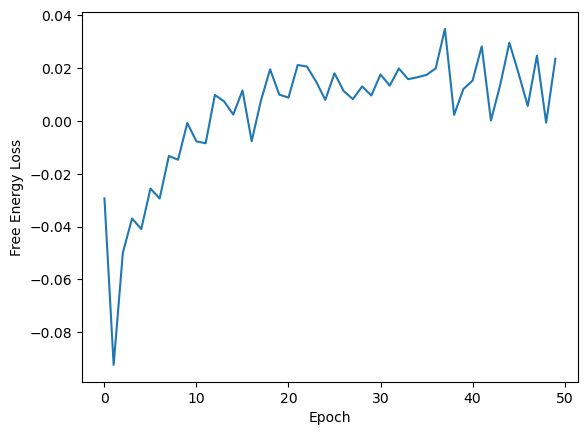

In [51]:
plt.plot([metrics[epoch]['loss_amp'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

In [52]:
samples = model_amp.apply(
    {"params": state_amp.params},
    n_samples=10_000,
    T_schedule=jnp.ones(300) * 1.2,
    rng=rng,
    method=RBM.generate
)

rel_freq = samples.mean(0)
rel_freq

Array([0.15439999, 0.1426    , 0.117     , 0.1748    , 0.1284    ,
       0.1396    , 0.15689999, 0.1514    , 0.1604    , 0.125     ],      dtype=float32)

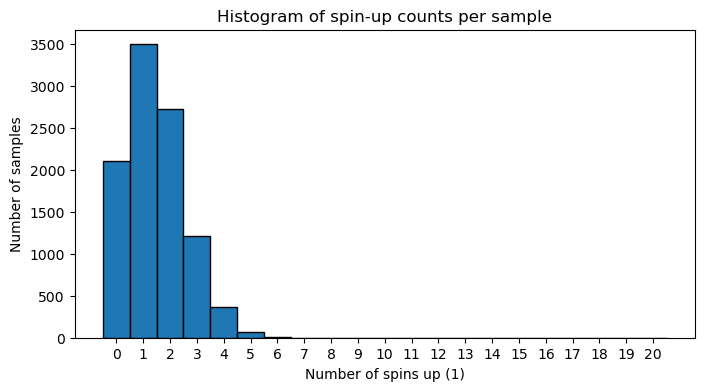

In [53]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(22), align='left', edgecolor='black')
plt.xticks(range(21))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

In [54]:
# compare with actual frequencies from first
empirical_freq = jnp.zeros(visible_units)
num_total = 0

for batch in loader_amp:
    for arr in batch.values():
        empirical_freq += jnp.sum(arr, axis=0)
        num_total += arr.shape[0]

empirical_freq = empirical_freq / num_total
empirical_freq

Array([0.0959375 , 0.09953125, 0.09640625, 0.0984375 , 0.09984375,
       0.10265625, 0.09671875, 0.101875  , 0.109375  , 0.09921875],      dtype=float32)

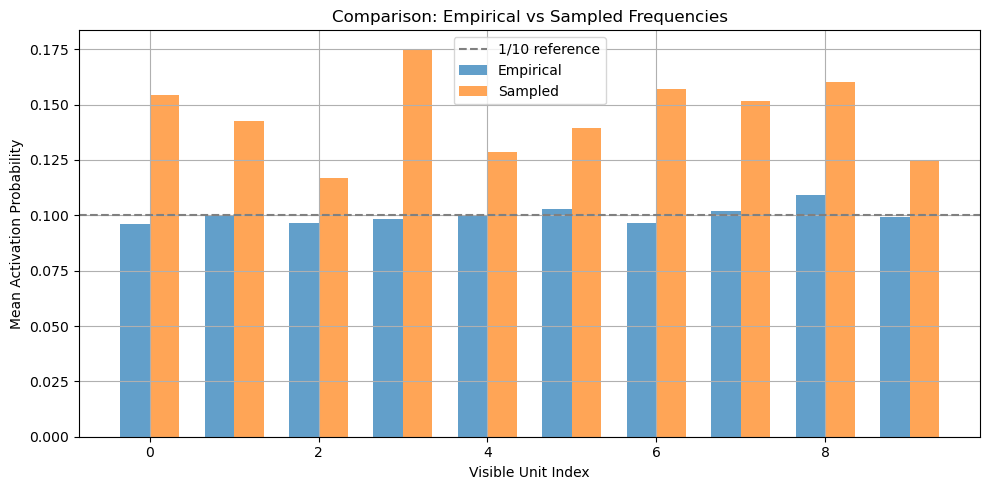

In [55]:
# Plotting comparison
plt.figure(figsize=(10, 5))
x = np.arange(visible_units)
width = 0.35

plt.bar(x - width/2, empirical_freq, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, rel_freq, width, label="Sampled", alpha=0.7)
plt.axhline(1 / visible_units, linestyle='--', color='gray', label=f'1/{visible_units} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Probability")
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()